# Setting up general imports and boto3

In [ ]:
# General Setup
import pandas as pd
import numpy as np
# !pip install boto3
import boto3
import os
import time
import pickle

# AWS Credentials and Settings
access_key = 'ACCESS_KEY'
secret_key = 'SECRET_ACCESS_KEY'

os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F").replace("+", "%2B")

aws_region = 'us-east-1'

s3 = boto3.client(
    service_name='s3',
    region_name=aws_region,
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key
)

#Setting up Spark

In [ ]:
# Spark Setup
# Setting up Spark
# !pip install pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession, Row, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, explode, col, collect_list, regexp_replace, split, expr, length, concat_ws, count, size, first, broadcast, monotonically_increasing_id
from pyspark.sql.types import ArrayType, StringType, IntegerType, FloatType, DoubleType
from pyspark import sql
import pyspark.pandas as ps

# Set up Spark
spark = SparkSession.builder \
    .appName("PicklesPlus") \
    .config("spark.hadoop.fs.s3a.access.key", access_key) \
    .config("spark.hadoop.fs.s3a.secret.key", secret_key) \
    .config("spark.hadoop.fs.s3a.endpoint","s3." + aws_region + ".amazonaws.com") \
    .config("spark.executor.memory", "15g") \
    .config("spark.executor.cores", "2") \
    .config("spark.default.parallelism", "4") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

#Importing ML stuff

In [ ]:
# Importing ML libraries
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.stat import Correlation, ChiSquareTest, Summarizer

from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF, VectorAssembler, StandardScaler, OneHotEncoder, Normalizer, StopWordsRemover, CountVectorizer

from pyspark.mllib.linalg import Vectors, VectorUDT
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix

from pyspark.ml.clustering import KMeans

from pyspark.ml.evaluation import ClusteringEvaluator

# Load in data

In [ ]:
main = spark.read.parquet('s3a://kagglespotify6k/raw/main_dataset.parquet/')

all_tracks = spark.read.parquet('s3a://kagglespotify6k/trusted/all_tracks/')


# main contains some duplicate columns
columns_to_drop = ['key', 'loudness', 'mode', 'tempo', 'time_signature']
main_merge = main.drop(*columns_to_drop)

# Join the 2 dataframes
merged_df = all_tracks.join(main_merge, all_tracks['track_uri'] == main_merge['track_uri'])
merged_df = merged_df.drop(main_merge['track_uri'])
merged_df = merged_df.withColumn('playlist_uris', expr("substring(split(playlist_uris, ':')[2], 1, length(split(playlist_uris, ':')[2]) - 2)"))
merged_df = merged_df.withColumn('playlist_uris_list', split('playlist_uris', ',\s'))

merged_df.write.mode('overwrite').parquet('s3a://kagglespotify6k/trusted/merged_main_tracks_all/')

# 28.79 seconds

In [ ]:
merged_df.select('playlist_uris_list').collect()[4]

Out[7]: Row(playlist_uris_list=['6QOC6seTuY5y0J0KwJCJBO'])

#All Features v1


In [ ]:
# Change all the columns from string to appropriate data type


merged = merged.withColumn('key', col('key').cast(IntegerType()))\
    .withColumn('loudness', col('loudness').cast(FloatType()))\
    .withColumn('mode', col('mode').cast(IntegerType()))\
    .withColumn('tempo', col('tempo').cast(FloatType()))\
    .withColumn('time_signature', col('time_signature').cast(IntegerType()))\
    .withColumn('danceability', col('danceability').cast(FloatType()))\
    .withColumn('energy', col('energy').cast(FloatType()))\
    .withColumn('speechiness', col('speechiness').cast(FloatType()))\
    .withColumn('acousticness', col('acousticness').cast(FloatType()))\
    .withColumn('instrumentalness', col('instrumentalness').cast(FloatType()))\
    .withColumn('liveness', col('liveness').cast(FloatType()))\
    .withColumn('valence', col('valence').cast(FloatType()))

feat_df = merged_df.select(col('name'), col('track_uri'), col('key'), col('loudness'), col('mode'), col('tempo'), col('time_signature'), col('danceability'), col('energy'), col('speechiness'), col('acousticness'), col('instrumentalness'), col('liveness'), col('valence'), col('artists_genres'), col('artists_names'))

feat_df = feat_df.na.fill(0)

feat_df.write.mode('overwrite').parquet('s3a://kagglespotify6k/trusted/feature_df_30k')

In [ ]:
# First, process the genre vector

# Vectorization on genres

# artists_genres already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
# Anything around numFeatures = 100 or above only generates 0's
hashingTF = HashingTF(numFeatures = 47, inputCol = 'artists_genres', outputCol = 'genre_hash')
feat_df_ghash = hashingTF.transform(feat_df)

idf = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')
idfModel = idf.fit(feat_df_ghash)
feat_df_gidf = idfModel.transform(feat_df_ghash)

# Remove uneccesary columns
feat_df_prep = feat_df_gidf.select(col('name'), col('track_uri'), col('key'), col('loudness'), col('mode'), col('tempo'), col('time_signature'), col('danceability'), col('energy'), col('speechiness'), col('acousticness'), col('instrumentalness'), col('liveness'), col('valence'), col('genre_idf'), col('artists_names'))

# Vector Assembler

assembler =  VectorAssembler(inputCols = ['key', 'loudness', 'mode', 'tempo', 'time_signature', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'genre_idf'], outputCol = 'features')

feat_df_va = assembler.transform(feat_df_prep)

# Took 21.82 seconds
# 29.30 seconds
# adding artists_names -> 7.65 seconds ??
# 26.69 seconds

In [ ]:
viewpd = feat_df_ghash.toPandas()
viewpd.head()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field genre_hash. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,name,track_uri,key,loudness,mode,tempo,time_signature,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,artists_genres,artists_names,genre_hash
0,Drop That Kitty (feat. Charli XCX & Tinashe),0Bi1amRigSOIzLc21hOH6p,11,-5.667,0,106.021004,4,0.874,0.712,0.0315,0.0283,0.088700,0.0824,0.585,"[dance pop, hip hop, pop, pop rap, r&b, southe...",['Ty Dolla $ign'],"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,From the Ground Up - Single Version,0AdjJ2SaOeb5bPJ67nDbsW,9,-5.431,1,101.213997,4,0.524,0.586,0.0262,0.3560,0.000000,0.1210,0.285,"[contemporary country, country, country road, ...",['Dan + Shay'],"(0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ..."
2,Ghost Town,0bvEKvSwtUFIz3cTo0Otjg,6,-4.678,0,79.963997,4,0.472,0.903,0.0471,0.1180,0.000002,0.1300,0.313,"[contemporary country, country, country road]",['Jake Owen'],"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,Be Somebody,0eQjA54TJkwTHDJKG8OkRg,2,-6.440,1,133.906998,4,0.487,0.835,0.0588,0.0274,0.007540,0.2110,0.311,"[modern rock, rock]",['Kings of Leon'],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Good Things,0YUznciNBOLDf2laf7N5cb,5,-5.820,1,94.221001,4,0.464,0.677,0.0525,0.3840,0.000024,0.1100,0.778,"[neo soul, pop soul, r&b]",['Aloe Blacc'],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# All Features V1 with cosine sim

In [ ]:
# Version 1
# Using cosine similarity

# Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
def cos_sim(vec1, vec2):
    return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# Convert cosine similarity function to spark UDF
cos_sim_udf = udf(cos_sim, FloatType())

# Create the "shell" of the similarity matrix dataframe with crossJoin
# make the rows = columns (in this case we want track_uri vs track_uri), so total entries would be n^2
to_vector = udf(lambda vec: Vectors.dense(vec), VectorUDT())
df1 = feat_df_va.withColumnRenamed('track_uri', 'track_uri1').withColumn('features_1', to_vector('features'))
df2 = feat_df_va.withColumnRenamed('track_uri', 'track_uri2').withColumn('features_2', to_vector('features'))

cross_joined = df1.crossJoin(df2)

# Create the similarity matrix
sim_df = cross_joined.withColumn('similarity', cos_sim_udf('features_1', 'features_2'))
sim_df = sim_df.select('track_uri1', 'track_uri2', 'similarity')

from pyspark.sql.functions import col

# Adding song names to the similarity matrix
sim_df = sim_df.join(feat_df.select(col("track_uri").alias("track_uri2"), col("name").alias('rec_song'), col('artists_names'), col('artists_genres')), on="track_uri2", how="left")
sim_df = sim_df.join(feat_df_va.select(col("track_uri").alias("track_uri1"), col("name").alias('orig_song')), on="track_uri1", how="left")

# Now 'sim_df_with_song' will have an additional column 'rec_song' containing the song names -> 1.42 seconds
# sim_df with song name and artists names

In [ ]:
sim_df.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|          track_uri1|          track_uri2|similarity|            rec_song|       artists_names|      artists_genres|           orig_song|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|0Bi1amRigSOIzLc21...|0Bi1amRigSOIzLc21...|       1.0|Drop That Kitty (...|   ['Ty Dolla $ign']|[dance pop, hip h...|Drop That Kitty (...|
|0Bi1amRigSOIzLc21...|0AdjJ2SaOeb5bPJ67...| 0.9972351|From the Ground U...|      ['Dan + Shay']|[contemporary cou...|Drop That Kitty (...|
|0Bi1amRigSOIzLc21...|0bvEKvSwtUFIz3cTo...|0.99689716|          Ghost Town|       ['Jake Owen']|[contemporary cou...|Drop That Kitty (...|
|0Bi1amRigSOIzLc21...|0eQjA54TJkwTHDJKG...| 0.9930705|         Be Somebody|   ['Kings of Leon']| [modern rock, rock]|Drop That Kitty (...|
|0Bi1amRigSOIzLc21...|0YUzn

In [ ]:
def song_rec_m1(track_uri, num_rec):
    fin_rec = sim_df.filter((sim_df['track_uri1'] == track_uri) & (sim_df['track_uri2'] != track_uri)).orderBy(col("similarity").desc()).limit(num_rec).select('track_uri2', 'rec_song', 'artists_names', 'similarity')
    songs = fin_rec.collect()
    for num, row in enumerate(songs, start = 1):
        print(f"{num}) {row['rec_song']} by {row['artists_names']}, Score: {row['similarity']}")

# Print function
# 1.51 minutes for 10 songs

In [ ]:
song_rec_m1('00qOE7OjRl0BpYiCiweZB2', 10)

1) Unforgiven by ['Joe Cocker'], Score: 0.9995737671852112
2) Virginia by ['The Marshall Tucker Band'], Score: 0.9994796514511108
3) Garten Eden by ['Crystal F'], Score: 0.9994605183601379
4) Pour Some Sugar On Me (2012) by ['Def Leppard'], Score: 0.9994540214538574
5) Rich Girl by ['Daryl Hall & John Oates'], Score: 0.9994521141052246
6) Halo by ['Slash'], Score: 0.9994503855705261
7) Stop Messin' Around by ['Aerosmith'], Score: 0.999445915222168
8) Ciao by ['Russian Village Boys'], Score: 0.9994267821311951
9) Daddy WTF? by ['Russian Village Boys', 'Jimmy Pop'], Score: 0.9994237422943115
10) Pour Some Sugar on Me by ['Def Leppard'], Score: 0.9994210004806519


# All Features V1 Visualizations

In [ ]:
# Graphing tools
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Most common genres

# Get counts and convert spark DF to pandas DF for plotting
explode_genres = feat_df.withColumn('genre', explode('artists_genres'))
genre_counts = explode_genres.groupBy('genre').agg(count('genre').alias('count')).orderBy(col('count').desc())
genre_counts_pd = genre_counts.toPandas()

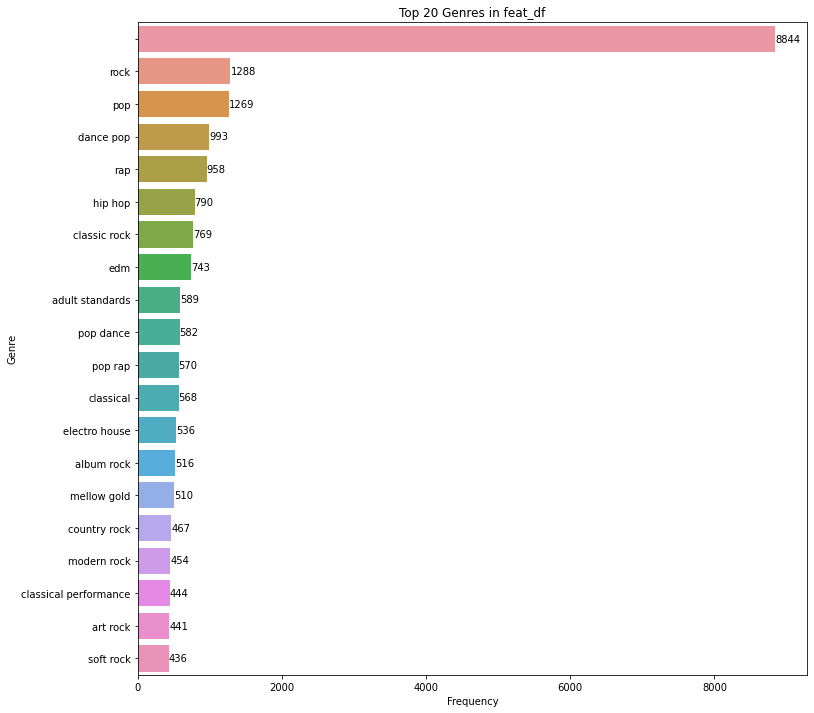

In [ ]:
# Most common genres

# Get counts and convert spark DF to pandas DF for plotting
explode_genres = feat_df.withColumn('genre', explode('artists_genres'))
genre_counts = explode_genres.groupBy('genre').agg(count('genre').alias('count')).orderBy(col('count').desc())
genre_counts_pd = genre_counts.toPandas()

# Bar Plot
plt.figure(figsize = (12, 12))
ax = sns.barplot(x = 'count', y = 'genre', data = genre_counts_pd[0:20])
ax.bar_label(ax.containers[0])
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.title('Top 20 Genres in feat_df')
plt.show()

In [ ]:
# Network Graph
network_df = sim_df.filter(sim_df['similarity'] > 0.95).select('orig_song', 'rec_song', 'similarity')
edges = network_df.select('orig_song', 'rec_song').collect()

import networkx as nx

G = nx.Graph()

# Add edges
for edge in edges:
    G.add_edge(edge[0], edge[1])

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Song Similarity Network Graph")
plt.show()

In [ ]:
# Individual Song
feat_df.filter(size(feat_df['artists_genres']) > 2).select('track_uri', 'name', 'artists_names', 'artists_genres').collect()[12000]

Out[94]: Row(track_uri='0EYKD5N0mldDeVTCzCfzqr', name='Thrift Shop', artists_names="['Tyler Ward', 'Lindsey Stirling']", artists_genres=['acoustic cover', 'channel pop', 'neo mellow', 'viral pop', 'bow pop', 'pop violin'])

In [ ]:
song_rec_m1('0EYKD5N0mldDeVTCzCfzqr', 20)

1) MALA MEMO by ['Carol Biazin'], Score: 0.998096227645874
2) Cannonball by ['Skylar Grey'], Score: 0.9979497194290161
3) Wear My Ring (Little Angel with the Bottle) by ['Bart Crow'], Score: 0.9979487061500549
4) Bad Reputation by ['Mike Ryan'], Score: 0.9978235960006714
5) New Blood by ['Zayde Wølf'], Score: 0.9977883696556091
6) Push It On Me - From “What Now?” by ['Kevin Hart'], Score: 0.9976405501365662
7) We Are Legends by ['Valley Of Wolves'], Score: 0.9975897669792175
8) Wide Open Space by ['Mansun'], Score: 0.9975830912590027
9) Sightwaster by ['Somali Yacht Club'], Score: 0.9975539445877075
10) Burn It At Both Ends by ['Randall King'], Score: 0.9975479245185852
11) Shameless by ['Sofia Karlberg'], Score: 0.9975363612174988
12) Yegle Nesh by ['Hailu Mergia'], Score: 0.9975076913833618
13) Creepout by ['Creepout'], Score: 0.9974854588508606
14) La Hierbabuena by ['El Condesa De Bertin Gomez Jr'], Score: 0.9974738955497742
15) Da Draussen by ['Sarah Lesch'], Score: 0.997456312179

In [ ]:
# # Individual Song
# feat_df.filter(size(feat_df['artists_genres']) > 2).select('track_uri', 'name', 'artists_names', 'artists_genres').collect()[12000]

# Out[94]: Row(track_uri='0EYKD5N0mldDeVTCzCfzqr', name='Thrift Shop', artists_names="['Tyler Ward', 'Lindsey Stirling']", artists_genres=['acoustic cover', 'channel pop', 'neo mellow', 'viral pop', 'bow pop', 'pop violin'])

# For 1 song, filter the similarity matrix and convert into pandas DF
graph_song_df = sim_df.filter(col('track_uri1') == '0EYKD5N0mldDeVTCzCfzqr').select('orig_song', 'rec_song', 'artists_names', 'artists_genres', 'similarity')
graph_song_pd = graph_song_df.toPandas()

# 5 minutes
# 1.49 minutes

In [ ]:
graph_song_pd.head()

,orig_song,rec_song,artists_names,artists_genres,similarity
0,Thrift Shop,Drop That Kitty (feat. Charli XCX & Tinashe),['Ty Dolla $ign'],"[dance pop, hip hop, pop, pop rap, r&b, southe...",0.993991
1,Thrift Shop,From the Ground Up - Single Version,['Dan + Shay'],"[contemporary country, country, country road, ...",0.994974
2,Thrift Shop,Ghost Town,['Jake Owen'],"[contemporary country, country, country road]",0.994943
3,Thrift Shop,Be Somebody,['Kings of Leon'],"[modern rock, rock]",0.992939
4,Thrift Shop,Good Things,['Aloe Blacc'],"[neo soul, pop soul, r&b]",0.994442


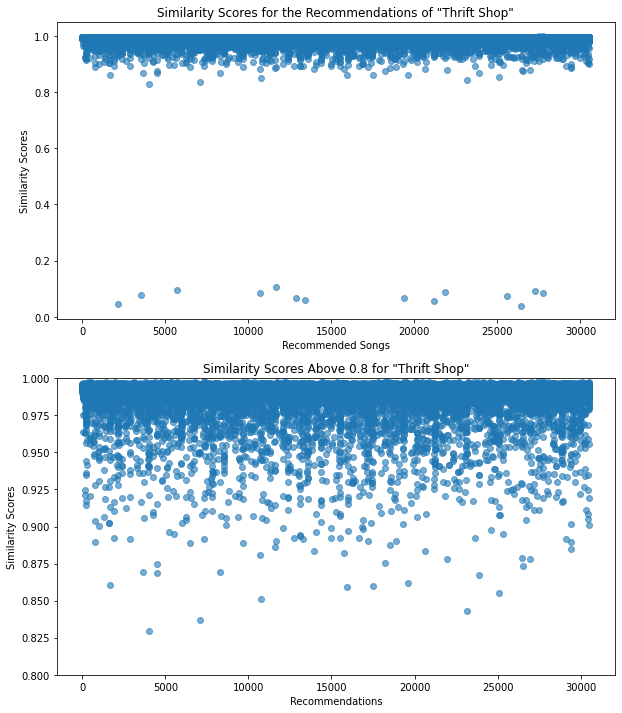

In [ ]:
# Scatter plot of similarity scores
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 12))

ax1.scatter(range(len(graph_song_pd)), graph_song_pd['similarity'], alpha = 0.6)
ax1.set_xlabel('Recommended Songs')
ax1.set_ylabel('Similarity Scores')
ax1.set_title('Similarity Scores for the Recommendations of "Thrift Shop"')

upper_recs = graph_song_pd.loc[graph_song_pd['similarity'] > 0.8]
ax2.scatter(range(len(upper_recs)), upper_recs['similarity'], alpha = 0.6)
ax2.set_xlabel('Recommendations')
ax2.set_ylabel('Similarity Scores')
ax2.set_title('Similarity Scores Above 0.8 for "Thrift Shop"')
ax2.set_ylim(0.8, 1)

plt.show()

In [ ]:
# Looking into the cosine similarities for the genres
only_genre_feat = feat_df_gidf.select(col('name'), col('track_uri'), col('genre_idf'), col('artists_names'))
g_df1 = only_genre_feat.withColumnRenamed('track_uri', 'track_uri1').withColumn('genre_idf_vec1', to_vector('genre_idf'))
g_df2 = only_genre_feat.withColumnRenamed('track_uri', 'track_uri2').withColumn('genre_idf_vec2', to_vector('genre_idf'))

g_cross_joined = g_df1.crossJoin(g_df2)

# Create the similarity matrix
g_sim_df = g_cross_joined.withColumn('similarity', cos_sim_udf('genre_idf_vec1', 'genre_idf_vec2'))
g_sim_df = g_sim_df.select('track_uri1', 'track_uri2', 'similarity')
# graph_song_df = sim_df.filter(col('track_uri1') == '0EYKD5N0mldDeVTCzCfzqr').select('orig_song', 'rec_song', 'similarity')

/databricks/python/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


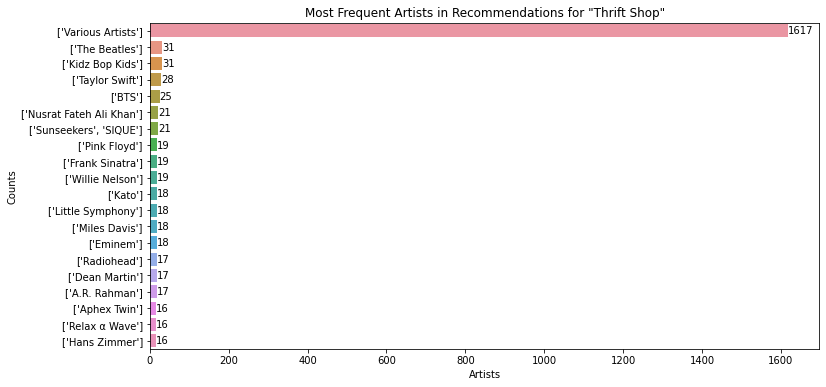

In [ ]:
# Most common artists for this song
explode_artists = upper_recs.explode('artists_names')
artists_counts = explode_artists['artists_names'].value_counts()
artists_counts_df = artists_counts.reset_index()
artists_counts_df.columns = ['artist', 'count']

plt.figure(figsize = (12,6))
ax = sns.barplot(artists_counts_df['count'], artists_counts_df['artist'][0:20])
ax.bar_label(ax.containers[0])
plt.xlabel('Artists')
plt.ylabel('Counts')
plt.title('Most Frequent Artists in Recommendations for "Thrift Shop"')
plt.show()

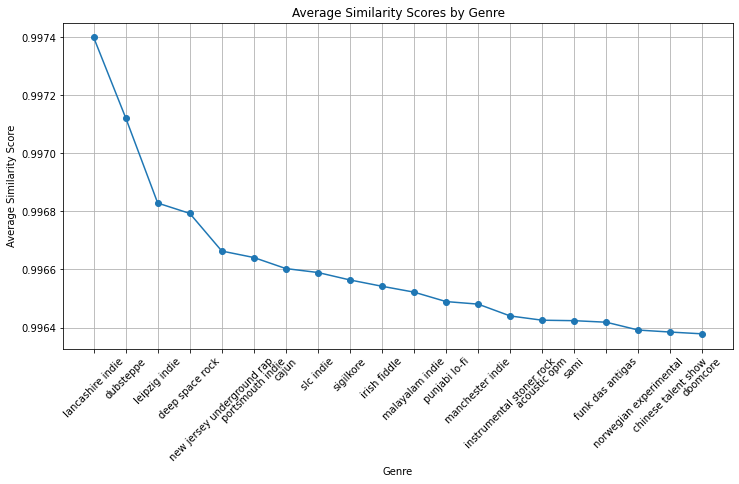

In [ ]:
# Line graph for average genre similarity
explode_genres = graph_song_pd.explode('artists_genres')
genre_mean_sim = explode_genres.groupby('artists_genres')['similarity'].mean().reset_index()
genre_mean_sim.columns = ['genre', 'mean_similarity']
genre_mean_sim = genre_mean_sim.sort_values('mean_similarity', ascending = False)
genre_mean_sim = genre_mean_sim.head(20)

plt.figure(figsize=(12, 6))
plt.plot(genre_mean_sim['genre'], genre_mean_sim['mean_similarity'], marker='o')
plt.xlabel('Genre')
plt.ylabel('Average Similarity Score')
plt.title('Average Similarity Scores by Genre')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
genre_mean_sim.shape

Out[164]: (3838, 2)

# All Features V2 (with Playlists)

In [ ]:
# # Identifiers
# # name, track_uri, artists_names

# # Categorical
# # Song characteristics: key, mode, time_signature
# # Genre/category vec: artists_genres, playlist_uris_list

# # Numerical
# # Song Measures: loudness, tempo
# # Song "character" (0 - 1.0): instrumentalness, speechiness, acousticness
# #   instrumentalness: predicts whether a track contains no vocals, or its more how prevalent vocals are in the track
# #       Rap would have higher vocalness so low instrumentalness
# # Vibe characteristics (0 - 1.0): danceability, energy, liveness, valence
# #   energy: intensity and activity, 0 - 1.0, more energetic = faster, louder, noisier (like death metal has high energy while Bach has low)
# #   liveness: presence of audience in the recording, really for live vs studio recorded
# #   valence: musical positiveness, how "happy" a song is
# # Popularity vec(?): popularity, artists_popularities, artists_followers

# merged = spark.read.parquet('s3a://kagglespotify6k/trusted/merged_main_tracks_all/')

# merged = merged.withColumn('loudness', col('loudness').cast(FloatType()))\
#     .withColumn('tempo', col('tempo').cast(FloatType()))\
#     .withColumn('danceability', col('danceability').cast(FloatType()))\
#     .withColumn('energy', col('energy').cast(FloatType()))\
#     .withColumn('speechiness', col('speechiness').cast(FloatType()))\
#     .withColumn('acousticness', col('acousticness').cast(FloatType()))\
#     .withColumn('instrumentalness', col('instrumentalness').cast(FloatType()))\
#     .withColumn('liveness', col('liveness').cast(FloatType()))\
#     .withColumn('valence', col('valence').cast(FloatType()))

# feat_df2 = merged.select(col('name'), col('track_uri'), col('artists_names'),
#                          col('artists_genres'), col('playlist_uris_list'),
#                          col('key'), col('mode'), col('time_signature'),
#                          col('tempo'), col('loudness'),
#                          col('acousticness'), col('instrumentalness'), col('speechiness'),
#                          col('valence'), col('danceability'), col('energy'), col('liveness'))

# feat_df2 = feat_df2.dropna(how = 'any')
# # feat_df2.write.mode('overwrite').parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')

# # 24 seconds
# # 20.18 seconds

##Attempt 1 - All of em

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')

# ## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# # artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
# hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# hashingTF_playlists = HashingTF(numFeatures = 100, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
# idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

# ## Vectorizing the music technique categorical features (key, mode, time_signature)
# # Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# #   StringIndexer only takes in 1 column at a time
# categ_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index').fit(feat_df2) for column in ['key', 'mode', 'time_signature']]

# # Encode with One Hot encoding
# categ_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+'_vec') for indexer in categ_indexers]

# categ_VecAssembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in categ_encoders], outputCol='categorical_features')

# ## Vectorizing instrumental features
# instr_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness'], outputCol = 'instrument_features')
# instr_scaler = StandardScaler(inputCol = 'instrument_features', outputCol = 'scaled_instrument_features')

# ## Vecotirzing the "vibe"/emotional confidence features
# emo_VecAssembler = VectorAssembler(inputCols = ['valence', 'danceability', 'energy', 'liveness'], outputCol = 'emo_features')
# emo_scaler = StandardScaler(inputCol = 'emo_features', outputCol = 'scaled_emo_features')

# ## Final feature vector
# final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'playlist_idf', 'categorical_features', 'scaled_instrument_features', 'scaled_emo_features'], outputCol='features')

# ## Pipeline
# pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists] + categ_indexers + categ_encoders + [categ_VecAssembler, instr_VecAssembler, instr_scaler, emo_VecAssembler, emo_scaler, final_VecAssembler])

# model = pipeline.fit(feat_df2)
# model_df = model.transform(feat_df2)

# # model.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

# ##########################################

# # ~270,000 rows
# # Run 1: 49.22 seconds - without the write
# # Run 1a (with write): 2.13 minutes
# # Run 2 (Reduced numFeatures from 120,000 -> 120): 1.98 minutes
# # Run 3 (Reduced numFeatures to 50): 1.43 minutes

# # 1.56 minutes

# # 21.06 seconds

In [ ]:
"""
Main issue here lies in the model, way too complicated
Can't even do .collect()
"""

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [ ]:
# # Cache the DataFrame
# fin_feat.cache()
# fin_feat_limit = fin_feat.limit(30000)

# # Referenced: https://stackoverflow.com/questions/57530010/spark-scala-cosine-similarity-matrix
# # https://stackoverflow.com/questions/65907514/when-is-it-appropriate-to-use-a-udf-vs-using-spark-functionality
# # https://blog.damavis.com/en/avoiding-udfs-in-apache-spark/
# # https://stackoverflow.com/questions/46758768/calculating-the-cosine-similarity-between-all-the-rows-of-a-dataframe-in-pyspark

# # Unique numeric index because number easier to manipulate than string identifier
# model_df_test = fin_feat_limit.withColumn("index", monotonically_increasing_id())

# ## Convert the vectors
# def row_to_vec(row):
#     row_vec = MLLibVectors.sparse(row['features'].size, row['features'].indices, row['features'].values)
#     return IndexedRow(row['index'], row_vec)

# ## RDD for spark
# indexed_rows = model_df_test.rdd.map(row_to_vec)

# ## Create matrix
# indexed_matrix = IndexedRowMatrix(indexed_rows)

# ## Compute cosine
# # Original cosine similarity function:
# # # Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
# # def cos_sim(vec1, vec2):
# #     return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# # Original function computed the norms of each vector
# # Broadcast and map first to get the proper values for the math
# norms = indexed_matrix.rows.map(lambda row: (row.index, row.vector.norm(2))).collectAsMap()
# bc_norms = spark.sparkContext.broadcast(norms)


# def cos_sim(row):
#     index1, vec1 = row.index, row.vector
#     sim_scores = [(index2, float(vec1.dot(vec2) / (bc_norms.value[index1] * bc_norms.value[index2]))) for index2, vec2 in bc_norms.value.items() if index1 != index2]
#     return [Row(index1=index1, index2=index2, similarity=sim) for index2, sim in sim_scores]


# matrix_computed = cos_sim_matrix(indexed_matrix)

# # Create sim_df dataframe
# flattened_rdd = indexed_matrix.rows.flatMap(cos_sim).collect()
# sim_df = spark.createDataFrame(flattened_rdd)

# # Adding the additional track details
# sim_df = (
#     # Join to get identifiers, genres, artists
#     sim_df.join(model_df_test.select("index", "track_uri", "name", "artists_names", "artists_genres"), similarity_df.index1 == model_df_test.index)
#     # Rename columns
#     .selectExpr("track_uri as track_uri1", "name as orig_song", "index2", "similarity", "artists_names", "artists_genres")
#     # Join to get rec_song
#     .join(model_df_test.select("index", "track_uri", "name"), similarity_df.index2 == model_df_test.index)
#     .selectExpr("track_uri1", "orig_song", "track_uri as track_uri2", "name as rec_song", "similarity", "artists_names", "artists_genres")
# )


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-4440315177042413>:45
     42 matrix_computed = cos_sim_matrix(indexed_matrix)
     44 # Create sim_df dataframe
---> 45 flattened_rdd = indexed_matrix.rows.flatMap(cos_sim).collect()
     46 sim_df = spark.createDataFrame(flattened_rdd)
     48 # Adding the additional track details

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/rdd.py:1825, in RDD.collect(self)
   1823 with SCCallSiteSync(self.context):
   1824     assert self.ctx._jvm is not None
-> 1825     sock_

In [ ]:
"""
Takes way too long
Problem lies in the model and not the cosine similarity
Not even due to the massive increase in data, when limiting the model_df to 30k (the amount in V1) it still would not process
Possibly too many transformations and stages
"""

## Attempt 2: No playlists

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')

# ## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# # artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
# hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# ## Vectorizing the music technique categorical features (key, mode, time_signature)
# # Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# #   StringIndexer only takes in 1 column at a time
# categ_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index').fit(feat_df2) for column in ['key', 'mode', 'time_signature']]

# # Encode with One Hot encoding
# categ_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+'_vec') for indexer in categ_indexers]

# categ_VecAssembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in categ_encoders], outputCol='categorical_features')

# ## Vectorizing instrumental features
# instr_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness'], outputCol = 'instrument_features')
# instr_scaler = StandardScaler(inputCol = 'instrument_features', outputCol = 'scaled_instrument_features')

# ## Vecotirzing the "vibe"/emotional confidence features
# emo_VecAssembler = VectorAssembler(inputCols = ['valence', 'danceability', 'energy', 'liveness'], outputCol = 'emo_features')
# emo_scaler = StandardScaler(inputCol = 'emo_features', outputCol = 'scaled_emo_features')

# ## Final feature vector
# final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'categorical_features', 'scaled_instrument_features', 'scaled_emo_features'], outputCol='features')

# ## Pipeline
# pipeline = Pipeline(stages = [hashingTF_genres, idf_genres] + categ_indexers + categ_encoders + [categ_VecAssembler, instr_VecAssembler, instr_scaler, emo_VecAssembler, emo_scaler, final_VecAssembler])

# model = pipeline.fit(feat_df2)
# model_df = model.transform(feat_df2)

# # model.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

# ##########################################

# # Run 1: 54.94 seconds

In [ ]:
# # Using cosine similarity
# fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
# fin_feat_limit = model_df.limit(30000)
# fin_feat_limit.cache()

# # Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
# def cos_sim(vec1, vec2):
#     return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# # Convert cosine similarity function to spark UDF
# cos_sim_udf = udf(cos_sim, FloatType())

# # Create the "shell" of the similarity matrix dataframe with crossJoin
# # make the rows = columns (in this case we want track_uri vs track_uri), so total entries would be n^2
# to_vector = udf(lambda vec: Vectors.dense(vec), VectorUDT())
# df1 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri1').withColumn('features_1', to_vector('features'))
# df2 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri2').withColumn('features_2', to_vector('features'))

# cross_joined = df1.crossJoin(broadcast(df2))

# # Create the similarity matrix
# sim_df = cross_joined.withColumn('similarity', cos_sim_udf('features_1', 'features_2'))
# sim_df = sim_df.select('track_uri1', 'track_uri2', 'similarity')

# # Adding song names to the similarity matrix
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri2"), col("name").alias('rec_song'), col('artists_names'), col('artists_genres')), on="track_uri2", how="left")
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri1"), col("name").alias('orig_song')), on="track_uri1", how="left")

# sim_df.cache()

# # 3 seconds

Out[6]: DataFrame[track_uri1: string, track_uri2: string, similarity: float, rec_song: string, artists_names: string, artists_genres: array<string>, orig_song: string]

In [ ]:
"""
Still too expensive, I think the main issue lies in the numerical values - must reduce transformations
"""

# Attempt 3: Combined instrumental and emotional features into just music features

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
# feat_test = feat_df2.limit(100000)
# ## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# # artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
# hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# hashingTF_playlists = HashingTF(numFeatures = 100, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
# idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

# ## Vectorizing the music technique categorical features (key, mode, time_signature)
# # Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# #   StringIndexer only takes in 1 column at a time
# categ_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index').fit(feat_test) for column in ['key', 'mode', 'time_signature']]

# # Encode with One Hot encoding
# categ_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+'_vec') for indexer in categ_indexers]

# categ_VecAssembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in categ_encoders], outputCol='categorical_features')

# ## Vectorizing the confidence measure features (they are on a scale of 0 - 1.0)
# conf_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness', 'valence', 'danceability', 'energy', 'liveness'], outputCol = 'conf_features')
# conf_scaler = StandardScaler(inputCol = 'conf_features', outputCol = 'scaled_conf_features')

# ## Vectorizing the numeric features (loudness, tempo)
# numeric_VecAssembler = VectorAssembler(inputCols = ['loudness', 'tempo'], outputCol = 'numeric_features')

# ## Final feature vector
# final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'playlist_idf', 'categorical_features', 'scaled_conf_features', 'numeric_features'], outputCol='features')

# ## Pipeline
# pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists] + categ_indexers + categ_encoders + [categ_VecAssembler, conf_VecAssembler, conf_scaler, numeric_VecAssembler, final_VecAssembler])

# model = pipeline.fit(feat_test)
# model_df = model.transform(feat_test)

# # model.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

# ##########################################

# # Run 1(30k): 26.94 seconds
# # Run 2(100k): 23.79 seconds

In [ ]:
# fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
# fin_feat_limit = model_df.limit(100000)
# fin_feat_limit.cache()

# feat_index = fin_feat_limit.withColumn('index', monotonically_increasing_id())

# normalizer = Normalizer(inputCol='features', outputCol='norm')
# data = normalizer.transform(feat_index)
# rdd_data = data.select('index', 'norm').rdd

# def map_to_indexed_row(row):
#     # Convert pyspark.ml.linalg.SparseVector to pyspark.mllib.linalg.SparseVector
#     mllib_vector = Vectors.fromML(row['norm'])

#     return IndexedRow(row['index'], mllib_vector)

# indexed_rows_rdd = data.select("index", "norm").rdd.map(map_to_indexed_row)
# indexed_row_matrix = IndexedRowMatrix(indexed_rows_rdd)

# block_matrix = indexed_row_matrix.toBlockMatrix()

# dot = block_matrix.multiply(block_matrix.transpose())
# dot.toLocalMatrix().toArray()

# # dot_udf = F.udf(lambda x,y: float(x.dot(y)), DoubleType())
# # data.alias("i").join(data.alias("j"), F.col("i.index") < F.col("j.index"))\
# #     .select(
# #         F.col("i.index").alias("i"),
# #         F.col("j.index").alias("j"),
# #         dot_udf("i.norm", "j.norm").alias("dot"))\
# #     .sort("i", "j")\
# #     .show()


---------------------------------------------------------------------------
IllegalArgumentException                  Traceback (most recent call last)
File <command-4224105058046150>:23
     20 indexed_row_matrix = IndexedRowMatrix(indexed_rows_rdd)
     21 block_matrix = indexed_row_matrix.toBlockMatrix()
---> 23 # mat = IndexedRowMatrix(data.select("index", "norm").rdd.map(lambda row: IndexedRow(row.index, row.norm.toArray()))).toBlockMatrix()
     24 
     25 # dot_udf = F.udf(lambda x,y: float(x.dot(y)), DoubleType())
     26 # data.alias("i").join(data.alias("j"), F.col("i.index") < F.col("j.index"))\
     27 #     .select(
     28 #         F.col("i.index").alias("i"), 
     29 #         F.col("j.index").alias("j"), 
     30 #         dot_udf("i.norm", "j.norm").alias("dot"))\
     31 #     .sort("i", "j")\
     32 #     .show()

File /databricks/spark/python/pyspark/mllib/linalg/distributed.py:1592, in BlockMatrix.toLocalMatrix(self)
   1570 def toLocalMatrix(self) -> Matrix:
 

In [ ]:
# # Using cosine similarity
# fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
# fin_feat_limit = model_df.limit(100000)
# fin_feat_limit.cache()

# # Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
# def cos_sim(vec1, vec2):
#     return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# # Convert cosine similarity function to spark UDF
# cos_sim_udf = udf(cos_sim, FloatType())

# # Create the "shell" of the similarity matrix dataframe with crossJoin
# # make the rows = columns (in this case we want track_uri vs track_uri), so total entries would be n^2
# to_vector = udf(lambda vec: Vectors.dense(vec), VectorUDT())
# df1 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri1').withColumnRenamed('name', 'orig_song')\
#     .withColumn('features_1', to_vector('features'))
# df2 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri2').withColumnRenamed('name', 'rec_song')\
#     .withColumnRenamed('artists_names', 'rec_artists').withColumnRenamed('artists_genres', 'rec_song_genres')\
#     .withColumn('features_2', to_vector('features'))

# cross_joined = df1.crossJoin(broadcast(df2))

# # Create the similarity matrix
# sim_df = cross_joined.withColumn('similarity', cos_sim_udf('features_1', 'features_2'))
# sim_df = sim_df.select('track_uri1','orig_song', 'track_uri2', 'rec_song', 'rec_artists', 'rec_song_genres', 'similarity')

# # sim_df.cache()

# # 30k records - 1.56 seconds
# #

In [ ]:
# def song_rec_m2(track_uri, num_rec):
#     fin_rec = sim_df.filter((sim_df['track_uri1'] == track_uri) & (sim_df['track_uri2'] != track_uri)).orderBy(col("similarity").desc()).limit(num_rec)
#     songs = fin_rec.collect()
#     print(f'Original Song: {songs[0]["orig_song"]} by {songs[0]["artists_names"]}')
#     for num, row in enumerate(songs, start = 1):
#         print(f"{num}) {row['rec_song']} by {row['artists_names']}, Score: {row['similarity']}")

# song_rec_m2('008wXvCVu8W8vCbq5VQDlC', 10)

## Attempt 4: Combine numeric and conf

In [ ]:
feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
feat_test = feat_df2.limit(30000)
## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

hashingTF_playlists = HashingTF(numFeatures = 100, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

## Vectorizing the music technique categorical features (key, mode, time_signature)
# Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
#   StringIndexer only takes in 1 column at a time
categ_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index').fit(feat_test) for column in ['key', 'mode', 'time_signature']]

# Encode with One Hot encoding
categ_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+'_vec') for indexer in categ_indexers]

categ_VecAssembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in categ_encoders], outputCol='categorical_features')

## Vectorizing the confidence measure features (they are on a scale of 0 - 1.0)
numeric_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness', 'valence', 'danceability', 'energy', 'liveness', 'loudness', 'tempo'], outputCol = 'numeric_features')
numeric_scaler = StandardScaler(inputCol = 'numeric_features', outputCol = 'scaled_numeric_features')


## Final feature vector
final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'playlist_idf', 'categorical_features', 'scaled_numeric_features'], outputCol='features')

## Pipeline
pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists] + categ_indexers + categ_encoders + [categ_VecAssembler,  numeric_VecAssembler, numeric_scaler, final_VecAssembler])

model = pipeline.fit(feat_test)
model_df = model.transform(feat_test)

# model.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

##########################################

# Run 1: 30.03 seconds

In [ ]:
# # Using cosine similarity
# fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
# fin_feat_limit = model_df.limit(30000)
# fin_feat_limit.cache()

# # Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
# def cos_sim(vec1, vec2):
#     return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# # Convert cosine similarity function to spark UDF
# cos_sim_udf = udf(cos_sim, FloatType())

# # Create the "shell" of the similarity matrix dataframe with crossJoin
# # make the rows = columns (in this case we want track_uri vs track_uri), so total entries would be n^2
# to_vector = udf(lambda vec: Vectors.dense(vec), VectorUDT())
# df1 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri1').withColumn('features_1', to_vector('features'))
# df2 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri2').withColumn('features_2', to_vector('features'))

# cross_joined = df1.crossJoin(broadcast(df2))

# # Create the similarity matrix
# sim_df = cross_joined.withColumn('similarity', cos_sim_udf('features_1', 'features_2'))
# sim_df = sim_df.select('track_uri1', 'track_uri2', 'similarity')

# # Adding song names to the similarity matrix
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri2"), col("name").alias('rec_song'), col('artists_names'), col('artists_genres')), on="track_uri2", how="left")
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri1"), col("name").alias('orig_song')), on="track_uri1", how="left")

# sim_df.cache()

# # 3.37 seconds

Out[15]: DataFrame[track_uri1: string, track_uri2: string, similarity: float, rec_song: string, artists_names: string, artists_genres: array<string>, orig_song: string]

## Attempt 5: Put categorical features into 1 cateogorical column first

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
# feat_df2 = feat_df2.withColumn('categorical', F.array(col('key'),col('mode'), col('time_signature')))
# feat_test = feat_df2.limit(30000)

# ## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# # artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
# hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# hashingTF_playlists = HashingTF(numFeatures = 100, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
# idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

# ## Vectorizing the music technique categorical features (key, mode, time_signature)
# # Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# #   StringIndexer only takes in 1 column at a time

# hashingTF_categ = HashingTF(numFeatures = 100, inputCol = 'categorical', outputCol = 'categ_hash')
# idf_categ = IDF(inputCol = 'categ_hash', outputCol = 'categ_idf')

# ## Vectorizing the confidence measure features (they are on a scale of 0 - 1.0)
# numeric_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness', 'valence', 'danceability', 'energy', 'liveness', 'loudness', 'tempo'], outputCol = 'numeric_features')
# numeric_scaler = StandardScaler(inputCol = 'numeric_features', outputCol = 'scaled_numeric_features')


# ## Final feature vector
# final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'playlist_idf', 'categ_idf', 'scaled_numeric_features'], outputCol='features')

# ## Pipeline
# pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists, hashingTF_categ, idf_categ]+ [numeric_VecAssembler, numeric_scaler, final_VecAssembler])

# model = pipeline.fit(feat_test)
# model_df = model.transform(feat_test)

# # model.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

# ##########################################

# # Run 1: 22.74 seconds

In [ ]:
# # Using cosine similarity
# fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
# fin_feat.cache()

# # Referenced https://stackoverflow.com/questions/74343151/calculating-cosine-similarity-in-pyspark-dataframe
# def cos_sim(vec1, vec2):
#     return(float(vec1.dot(vec2) / (vec1.norm(2) * vec2.norm(2)))) # L2 norm

# # Convert cosine similarity function to spark UDF
# cos_sim_udf = udf(cos_sim, FloatType())

# # Create the "shell" of the similarity matrix dataframe with crossJoin
# # make the rows = columns (in this case we want track_uri vs track_uri), so total entries would be n^2
# to_vector = udf(lambda vec: Vectors.dense(vec), VectorUDT())
# df1 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri1').withColumn('features_1', to_vector('features'))
# df2 = fin_feat_limit.withColumnRenamed('track_uri', 'track_uri2').withColumn('features_2', to_vector('features'))

# cross_joined = df1.crossJoin(broadcast(df2))

# # Create the similarity matrix
# sim_df = cross_joined.withColumn('similarity', cos_sim_udf('features_1', 'features_2'))
# sim_df = sim_df.select('track_uri1', 'track_uri2', 'similarity')

# # Adding song names to the similarity matrix
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri2"), col("name").alias('rec_song'), col('artists_names'), col('artists_genres')), on="track_uri2", how="left")
# sim_df = sim_df.join(fin_feat_limit.select(col("track_uri").alias("track_uri1"), col("name").alias('orig_song')), on="track_uri1", how="left")

# sim_df.cache()

# # 3.69 seconds

Out[25]: DataFrame[track_uri1: string, track_uri2: string, similarity: float, rec_song: string, artists_names: string, artists_genres: array<string>, orig_song: string]

In [ ]:
# from pyspark.ml.linalg import DenseVector, SparseVector
# from pyspark.mllib.linalg import Vectors as MLLibVectors
# from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
# from pyspark.sql.functions import monotonically_increasing_id

# # Cache the DataFrame
# fin_feat.cache()
# fin_feat_limit = fin_feat.limit(30000)

# # Add a unique numerical index to each row
# model_df_test = fin_feat_limit.withColumn("index", monotonically_increasing_id())

# # Convert the vectors and create an RDD of IndexedRow
# def to_mllib_vector(row):
#     # Check if the vector is dense or sparse and convert accordingly
#     if isinstance(row['features'], DenseVector):
#         mllib_vector = MLLibVectors.dense(row['features'].toArray())
#     elif isinstance(row['features'], SparseVector):
#         mllib_vector = MLLibVectors.sparse(row['features'].size, row['features'].indices, row['features'].values)
#     else:
#         raise TypeError("Unsupported vector type: {}".format(type(row['features'])))
#     return IndexedRow(row['index'], mllib_vector)

# indexed_rows = model_df_test.rdd.map(to_mllib_vector)

# # Create an IndexedRowMatrix
# mat = IndexedRowMatrix(indexed_rows)

# # Compute the Gramian matrix
# gramian_matrix = mat.toRowMatrix().columnSimilarities()

# # Convert to DataFrame
# similarity_df = gramian_matrix.entries.map(lambda e: (e.i, e.j, e.value)).toDF(["index1", "index2", "similarity"])

# # Join with the original DataFrame to get track details
# similarity_df = (
#     similarity_df
#     .join(model_df_test.select("index", "track_uri", "name", "artists_names", "artists_genres"), similarity_df.index1 == model_df_test.index)
#     .selectExpr("track_uri as track_uri1", "name as orig_song", "index2", "similarity", "artists_names", "artists_genres")
#     .join(model_df_test.select("index", "track_uri", "name"), similarity_df.index2 == model_df_test.index)
#     .selectExpr("track_uri1", "orig_song", "track_uri as track_uri2", "name as rec_song", "similarity", "artists_names", "artists_genres")
# )


#All Features V3 (Double Model)


In [ ]:
# Identifiers
# name, track_uri, artists_names

# Categorical
# Song characteristics: key, mode, time_signature
# Genre/category vec: artists_genres, playlist_uris_list
#   Total 5141 "Unique" genres

# Numerical
# Song Measures: loudness, tempo

# Song "character" (0 - 1.0): instrumentalness, speechiness, acousticness
#   instrumentalness: predicts whether a track contains no vocals, or its more how prevalent vocals are in the track
#       Rap would have higher vocalness so low instrumentalness

# Vibe characteristics (0 - 1.0): danceability, energy, liveness, valence
#   energy: intensity and activity, 0 - 1.0, more energetic = faster, louder, noisier (like death metal has high energy while Bach has low)
#   liveness: presence of audience in the recording, really for live vs studio recorded
#   valence: musical positiveness, how "happy" a song is

# Popularity vec(?): popularity, artists_popularities, artists_followers

# Cluuster based on Categorical data
# 2 Vectors: Genre ['artists_genres', 'playlist_uris_list'], Song Characteristics ['key', 'mode', 'time_signature']

In [ ]:
# To reduce the overall number of rows needed to process:
#   Cluster songs to get their categorical similarities/groupings
#   Filter
#   Use other feature vectors for cosine similarity
#   Profit

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
# feat_df2 = feat_df2.withColumn('categorical', F.array(col('key'),col('mode'), col('time_signature')))
# feat_test = feat_df2.limit(30000)

# ## First, vectorize the textual categorical features (genre and playlists) into genre_vec
# # artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing

# hashingTF_genres = HashingTF(numFeatures = 100, inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# hashingTF_playlists = HashingTF(numFeatures = 100, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
# idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

# ## Vectorizing the music technique categorical features (key, mode, time_signature)

# hashingTF_categ = HashingTF(numFeatures = 100, inputCol = 'categorical', outputCol = 'categ_hash')
# idf_categ = IDF(inputCol = 'categ_hash', outputCol = 'categ_idf')

# ## Vector Assembler
# categ_VecAssembler = VectorAssembler(inputCols = ['genre_idf', 'categ_idf'], outputCol = 'categ_features')

# ## Pipeline, Fit, Transform
# pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists, hashingTF_categ, idf_categ, categ_VecAssembler])
# model1 = pipeline.fit(feat_test)

# feat_test2 = model1.transform(feat_test)

# # Using k-means model to group songs together
# # https://stats.stackexchange.com/questions/56500/what-are-the-main-differences-between-k-means-and-k-nearest-neighbours

# scaler = StandardScaler(inputCol = 'categ_features', outputCol = 'categ_features_scaled', withStd = True, withMean = False)
# scaler_model = scaler.fit(feat_test2)
# feat_test_catScale = scaler_model.transform(feat_test2)

# # Run 1: 17 seconds

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
# # feat_df2 = feat_df2.withColumn('categorical', F.array(col('key'),col('mode'), col('time_signature')))
# feat_test = feat_df2.limit(90000)

# # Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
# #   StringIndexer only takes in 1 column at a time

# # StringIndexer for categorical columns
# categ_indexers = [StringIndexer(inputCol=column, outputCol=column+'_index') for column in ['key', 'mode', 'time_signature']]

# # OneHotEncoder for indexed categorical columns
# categ_encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_vec") for indexer in categ_indexers]

# # HashingTF and IDF for text columns
# hashingTF_genres = HashingTF(inputCol = 'artists_genres', outputCol = 'genre_hash')
# idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

# hashingTF_playlists = HashingTF(inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
# idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

# # VectorAssembler to combine feature columns
# gen_cat_assembler_inputs = [encoder.getOutputCol() for encoder in categ_encoders] + ['genre_idf', 'playlist_idf']
# gen_cat_assembler = VectorAssembler(inputCols = gen_cat_assembler_inputs, outputCol = 'categ_features')

# # K-Means clustering
# kmeans = KMeans(k=50, featuresCol='g_categ_features', predictionCol='g_categ_prediction')

# # Define the pipeline
# pipeline1 = Pipeline(stages = categ_indexers + categ_encoders + [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists, gen_cat_assembler, kmeans])

# # Fit the pipeline to your data
# model1 = pipeline.fit(feat_test)
# model1_df = model1.transform(feat_test)

# # 30k rows
# # 3 minutes for k = 200
# # 41.70 minutes for k = 1000

# # 100k rows
# # k = 100 ->
# # 661 - 5:27

In [ ]:
# # Get all unique genres
# unique_genres_df = feat_df2.select(explode("artists_genres").alias("genre")).distinct()

# # K means to cluster the generes together --> produce a new reduced genre feature
# tokenizer = Tokenizer(inputCol="genre", outputCol="tokens")
# remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
# vectorizer = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
# idf = IDF(inputCol="rawFeatures", outputCol="features")
# kmeans_genre = KMeans(k = 1000, featuresCol="features", predictionCol="cluster")

# pipeline_genre = Pipeline(stages=[tokenizer, remover, vectorizer, idf, kmeans_genre])

# # Fit the model
# model_genre = pipeline_genre.fit(unique_genres_df)

# # Transform the data
# genre_clusters = model.transform(unique_genres_df)

# # Show results
# genre_clusters.show()

# genre_clusters.write.mode('overwrite').parquet('s3a://kagglespotify6k/models/mile_6_model/genre_clusters/')

+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|               genre|              tokens|            filtered|         rawFeatures|            features|cluster|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|                    |                  []|                  []| (2625,[1924],[1.0])|(2625,[1924],[7.8...|    703|
|            hard bop|         [hard, bop]|         [hard, bop]|(2625,[83,875],[1...|(2625,[83,875],[5...|    468|
|                jazz|              [jazz]|              [jazz]|    (2625,[8],[1.0])|(2625,[8],[3.6548...|    485|
|uk contemporary jazz|[uk, contemporary...|[uk, contemporary...|(2625,[8,41,42],[...|(2625,[8,41,42],[...|    250|
|            ska jazz|         [ska, jazz]|         [ska, jazz]|(2625,[8,80],[1.0...|(2625,[8,80],[3.6...|    980|
|     traditional ska|  [traditional, ska]|  [traditional, ska]|(2625,[48,80],[1

In [ ]:
# feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')
# g_clusters = spark.read.parquet('s3a://kagglespotify6k/models/mile_6_model/genre_clusters/')
# # Aggregating the categorical features to avoid having to one hot encode with a for loop
# feat_df2 = feat_df2.withColumn('categorical', F.array(col('key'),col('mode'), col('time_signature')))
# feat_test = feat_df2.limit(90000)

# ## Mapping essentially a new genre index to reduce total number of genres
# # Lay it out because it is long
# # https://stackoverflow.com/questions/26351382/how-to-convert-scala-rdd-to-map
# genre_cluster_map = (
#     g_clusters
#     .groupBy('genre')
#     .agg(collect_list('cluster').alias('genre_cluster'))
#     .rdd
#     .map(lambda row: (row.genre, list(set(row.genre_cluster))))
#     .collectAsMap()
# )

# def genres_to_clusters(genres_list, mapping):
#     cluster_list = [mapping[genre][0] for genre in genres_list if genre in mapping]
#     # set() to remove duplicates
#     return list(set(cluster_list))

# genre_change_udf = udf(lambda genres: genres_to_clusters(genres, genre_cluster_map), ArrayType(IntegerType()))

# # Create new column in feat_test which is essentailly a reduced artists_genre
# feat_test = feat_df2.withColumn('genre_cluster_predictions', genre_change_udf(col('artists_genres')))

# All Features V4: Final

In [ ]:
feat_df2 = spark.read.parquet('s3a://kagglespotify6k/trusted/feature_df_all270k/')

# Aggregating the categorical features to avoid having to one hot encode with a for loop
feat_df2 = feat_df2.withColumn('categorical', F.array(col('key'),col('mode'), col('time_signature')))
feat_test = feat_df2.limit(900)
## First, vectorize the textual categorical features (genre and playlists) into genre_vec

# artists_genres & playlist_uris_list already tokenized -> [genre_a, genre_b, genre_c], skip straight to hashing
hashingTF_genres = HashingTF(numFeatures = 50, inputCol = 'artists_genres', outputCol = 'genre_hash')
idf_genres = IDF(inputCol = 'genre_hash', outputCol = 'genre_idf')

hashingTF_playlists = HashingTF(numFeatures = 50, inputCol = 'playlist_uris_list', outputCol = 'playlist_hash')
idf_playlists = IDF(inputCol = 'playlist_hash', outputCol = 'playlist_idf')

## Vectorizing the music technique categorical features (key, mode, time_signature)
# Referenced: https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
#   StringIndexer only takes in 1 column at a time
hashingTF_categ = HashingTF(numFeatures = 50, inputCol = 'categorical', outputCol = 'categ_hash')
idf_categ = IDF(inputCol = 'categ_hash', outputCol = 'categ_idf')

## Vectorizing the confidence measure features (they are on a scale of 0 - 1.0)
conf_VecAssembler = VectorAssembler(inputCols = ['acousticness', 'instrumentalness', 'speechiness', 'valence', 'danceability', 'energy', 'liveness'], outputCol = 'conf_features')
# conf_scaler = StandardScaler(inputCol = 'conf_features', outputCol = 'scaled_conf_features')

## Final feature vector
final_VecAssembler = VectorAssembler(inputCols=['genre_idf', 'playlist_idf', 'categ_idf', 'conf_features'], outputCol='features')

## Pipeline
pipeline = Pipeline(stages = [hashingTF_genres, idf_genres, hashingTF_playlists, idf_playlists , hashingTF_categ, idf_categ, conf_VecAssembler, final_VecAssembler])

model = pipeline.fit(feat_test)
model_df = model.transform(feat_test)

# model_df.write().overwrite().save('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')

##########################################

# Run 1(30k): 26.94 seconds
# Run 2(100k): 23.79 seconds

In [ ]:
# Referenced: https://stackoverflow.com/questions/34121258/cosine-similarity-via-dimsum-in-spark
# https://spark.apache.org/docs/1.2.2/api/java/org/apache/spark/mllib/linalg/distributed/RowMatrix.html
# https://stackoverflow.com/questions/57530010/spark-scala-cosine-similarity-matrix

# model_df = spark.read.parquet('s3a://kagglespotify6k/models/mile_6_model/mile_6_model_cos_sim/')
fin_feat = model_df.select('name','track_uri','artists_names', 'artists_genres', 'playlist_uris_list','features')
fin_feat.cache()

# Unique numeric index because number easier to manipulate than string identifier
simfeat_test = fin_feat.withColumn("index", monotonically_increasing_id())

# Convert the vectors
def row_to_vec(row):
    row_vec = Vectors.sparse(row['features'].size, row['features'].indices, row['features'].values)
    return IndexedRow(row['index'], row_vec)

# RDD for spark
indexed_rows = simfeat_test.rdd.map(row_to_vec)

# Create an IndexedRowMatrix
matrix = IndexedRowMatrix(indexed_rows)

# Compute similarity with DIMSUM
matrix_cos = matrix.toRowMatrix().columnSimilarities()

# Convert to DataFrame
sim_df1 = matrix_cos.entries.map(lambda e: (e.i, e.j, e.value)).toDF(['index1', 'index2', 'similarity'])

sim_df2 = sim_df1.join(simfeat_test.select('index', 'track_uri', 'name', 'artists_names'), sim_df1.index2 == simfeat_test.index, 'left')\
    .withColumnRenamed('track_uri', 'rec_track_uri').withColumnRenamed('name', 'rec_song').withColumnRenamed('artists_names', 'rec_artists').drop('index')\
    .join(simfeat_test.select('index', 'track_uri', 'name', 'artists_names'),sim_df1.index1 == simfeat_test.index, 'left')\
    .withColumnRenamed('track_uri', 'orig_track_uri').withColumnRenamed('name', 'orig_song').withColumnRenamed('aritsts_names', 'orig_artists').drop('index')

In [ ]:
sim_df2.show()

+------+------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|index1|index2|          similarity|       rec_track_uri|              rec_song|         rec_artists|      orig_track_uri|           orig_song|       artists_names|
+------+------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|    52|   109| 0.06537204504606135|00rC38CxKlB12JUrF...|          Boogie Shoes| ['Various Artists']|00PmAZfpbNUvM0ub8...|          True To Me|['Few Wolves', 'H...|
|   124|   154| 0.11711306720024281|019uakFkY8fcPWMyx...|      The Way You Felt|   ['Alec Benjamin']|00xDcOBS1NwrxZlh3...|          Extraction|['Greg Howe', 'Vi...|
|    17|    65|  0.0337099931231621|00XoyOnSy2QjEr4p9...|           Naive Rider|   ['Grandbrothers']|00Aud5cYpOufUmlVm...|Red Right Hand (P...|['Nick Cave & The...|
|    19|  

In [ ]:

def song_rec_m2(track_uri, num_rec,sim_df):
    fin_rec = sim_df.filter((sim_df['orig_track_uri'] == track_uri) & (sim_df['rec_track_uri'] != track_uri)).orderBy(col("similarity").desc()).limit(num_rec)
    songs = fin_rec.collect()
    print(f'Original Song: {songs[0]["orig_song"]} by {songs[0]["artists_names"]}')
    for num, row in enumerate(songs, start = 1):
        print(f"{num}) {row['rec_song']} by {row['artists_names']}, Score: {row['similarity']}")


song_rec_m2('008wXvCVu8W8vCbq5VQDlC', 10, sim_df2)

Original Song: Django by ['Various Artists']
1) What’s Done Is Done by ['Various Artists'], Score: 0.20846909961254162
2) Deep Conversations by ['Various Artists'], Score: 0.20143189867937766
3) 12.38 (feat. 21 Savage, Ink & Kadhja Bonet) by ['Various Artists'], Score: 0.1900098497454659
4) Bloodborne by ['Various Artists'], Score: 0.18170295454421495
5) The Seventh Day by ['Various Artists'], Score: 0.17790313494287913
6) Schick Kunden drauf by ['Various Artists'], Score: 0.16994997617015326
7) The Way You Felt by ['Various Artists'], Score: 0.15704945132473405
8) Coming Out of the Dark by ['Various Artists'], Score: 0.15097027121927953
9) Star Eater by ['Various Artists'], Score: 0.1504223169124588
10) Pas le choix by ['Various Artists'], Score: 0.14322297480788665


#End

In [ ]:
"""
Considerations:
Apparently doing cosine similarity on large datasets is very expensive.
- Libraries like Spotify's Annoy or Facebook's FAISS offer efficient implementations

Crossjoins are expensive
- Instead of crossjoining the whole bih, essentially comparing EVERY song to EVERY song, try comparing to already similar songs
- So cluster first then cosine sim

Salting technique
- But it looks like im already doing that??

Spark MLLib DIMSUM algorithm
- Approximating cosine similarity on large dataets
- More efficent that full pairwise comparison

Distributed Matrix Operations
- "For certain types of data, you can represent your features as a distributed matrix and use matrix operations to compute similarities. This is a more advanced technique and requires a good understanding of linear algebra and Spark's distributed matrix types."

"""